In [4]:
# url for train data: https://transfer.sh/RyD0RfrNuu/mnist_train.csv -P data/
# url for test data: https://transfer.sh/NC2NJipGvn/mnist_test.csv -P data/
# Using transfer.sh to host the data

import os
import urllib.request
import pandas as pd

filepath_train = 'data/mnist_train.csv'
url_train = 'https://transfer.sh/RyD0RfrNuu/mnist_train.csv'
filepath_test = 'data/mnist_test.csv'
url_test = 'https://transfer.sh/NC2NJipGvn/mnist_test.csv'

if not os.path.exists(filepath_train):
  urllib.request.urlretrieve(url_train, filepath_train)

if not os.path.exists(filepath_test):
  urllib.request.urlretrieve(url_test, filepath_test)


data = pd.read_csv('data/mnist_train.csv')
data = pd.read_csv(url)
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Idea

Create 10 model, model i answer whether the picture is of the i-th digit

In [5]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class LossFunction:

    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def loss(self, a : np.ndarray): # a is the coefficient vector
        prob = sigmoid(np.dot(self.X, a))
        values = - self.y * np.log(prob) - (1 - self.y) * np.log(1 - prob)
        return np.nansum(values) / self.y.shape[0]
        # Vi han che gia tri ham loss function nen can chia trung binh
        # de tranh bi tran so giong normalize data

    def gradient(self, a : np.ndarray):
        prob = sigmoid(np.dot(self.X, a)) # aT * X or XT * a = tich vo huong
        sub_coefficient = -(self.y - prob) 
        return np.dot(self.X.T, sub_coefficient) / self.y.shape[0]
    
    def precision(self, a : np.ndarray):
        prob = sigmoid(np.dot(self.X, a))
        prob = np.array(prob >= 0.5, dtype=np.int32)
        return np.sum(prob == self.y) / self.y.shape[0]

### Data


In [6]:
X = data.drop('label', axis=1).values # Data ko chua label
# X shape m * 784
# Axis = 1 mean drop column
# Axis = 0 mean drop row

#append a column of 1s for ax + by + c (x, y, 1) and (a, b, c)
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = data['label'].values
X.shape, y.shape

((60000, 785), (60000,))

In [7]:
loss_functions = []
for digit in range(10):
    y_digit = np.array(y == digit, dtype=np.int32) # y_digit is a vector of 0 and 1
    loss_functions.append(LossFunction(X, y_digit))

In [8]:
loss_functions

### Train data

In [9]:
def gradient_descent(loss_func, starting_point, learning_rate = 0.00001, num_steps = 40, precision=0.00001):
    cur_point = starting_point
    for i in range(num_steps):
        grad = loss_func.gradient(cur_point)
        # print("Iteration {}: loss = {}, precision = {}".format(i, loss_func.loss(cur_point), loss_func.precision(cur_point)))
        cur_point = cur_point - learning_rate * grad
        if np.linalg.norm(grad) < precision:
            break
    return cur_point

In [10]:
optimal_points = []

for digit in range(10):
    optimal_point = gradient_descent(loss_functions[digit], np.zeros(X.shape[1]))
    print("Accuracy for digit {}: {}".format(digit, loss_functions[digit].precision(optimal_point)))
    optimal_points.append(optimal_point)

Accuracy for digit 0: 0.9843333333333333
Accuracy for digit 1: 0.98625
Accuracy for digit 2: 0.9673333333333334
Accuracy for digit 3: 0.96225
Accuracy for digit 4: 0.9729333333333333
Accuracy for digit 5: 0.9528166666666666
Accuracy for digit 6: 0.9795666666666667
Accuracy for digit 7: 0.9779166666666667
Accuracy for digit 8: 0.9358166666666666
Accuracy for digit 9: 0.9471333333333334


### Inference

In [11]:
def infer(X, optimal_points):
    prob = np.zeros((X.shape[0], 10))
    for digit in range(10):
        prob[:, digit] = sigmoid(np.dot(X, optimal_points[digit]))
    return np.argmax(prob, axis=1) # return index of max value in each row

In [12]:
prob = infer(X, optimal_points)

In [13]:
prob

array([3, 0, 4, ..., 5, 6, 8])

In [14]:
import matplotlib.pyplot as plt

def draw_digit(data, row_id):
    row = data.iloc[row_id]
    label = row['label']
    image = row.drop('label').values.reshape(28, 28)
    plt.title('Digit Label = {}'.format(label))
    plt.imshow(image, cmap='gray')
    plt.show()

In [15]:
data_test = pd.read_csv('data/mnist_test.csv')
X_test = data_test.drop('label', axis=1).values
X_test = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
y_test = data_test['label'].values


In [18]:
infer(np.array([X_test[2009]]), optimal_points)

array([8])

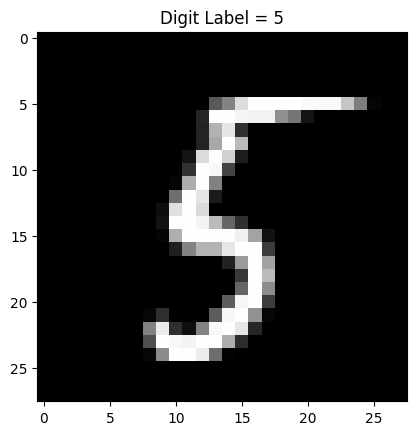

In [19]:
def evaluate(X, y, optimal_points):
    y_pred = infer(X, optimal_points)
    return np.sum(y_pred == y) / y.shape[0]
evaluate(X_test, y_test, optimal_points)

0.8781